In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import autokeras as ak
import time
from datetime import datetime
from matplotlib import pyplot
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [2]:
print(f"Execution started at {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}.")

Execution started at 2022-02-19 00:23:46.


In [3]:
import tensorflow as tf
if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TensorFlow.")

import tensorflow as tf
print("\nTensorFlow version: ", tf.__version__)
print("\nIs GPU available?", tf.test.is_gpu_available())
print("\nNum GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print("\nPhysical Devices: ", tf.config.list_physical_devices('GPU'))

from tensorflow.python.client import device_lib
print("\nLocal devices:", device_lib.list_local_devices())

Please install GPU version of TensorFlow.

TensorFlow version:  2.8.0
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.

Is GPU available? False

Num GPUs Available:  0

Physical Devices:  []

Local devices: [name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 17748979567492494945
xla_global_id: -1
]


In [4]:
filepath = "../Data Preprocessing/iot23_combined_200k.csv"
df = pd.read_csv(filepath)

In [5]:
df

,Unnamed: 0,duration,orig_bytes,resp_bytes,missed_bytes,orig_pkts,orig_ip_bytes,resp_pkts,resp_ip_bytes,label,...,conn_state_RSTOS0,conn_state_RSTR,conn_state_RSTRH,conn_state_S0,conn_state_S1,conn_state_S2,conn_state_S3,conn_state_SF,conn_state_SH,conn_state_SHR
0,0,2.998796,0,0,0.0,3.0,180.0,0.0,0.0,PartOfAHorizontalPortScan,...,0,0,0,1,0,0,0,0,0,0
1,1,0.000000,0,0,0.0,1.0,60.0,0.0,0.0,PartOfAHorizontalPortScan,...,0,0,0,1,0,0,0,0,0,0
2,2,0.000000,0,0,0.0,1.0,60.0,0.0,0.0,PartOfAHorizontalPortScan,...,0,0,0,1,0,0,0,0,0,0
3,3,2.998804,0,0,0.0,3.0,180.0,0.0,0.0,Benign,...,0,0,0,1,0,0,0,0,0,0
4,4,0.000000,0,0,0.0,1.0,60.0,0.0,0.0,Benign,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2800770,199994,0.000000,0,0,0.0,1.0,40.0,0.0,0.0,PartOfAHorizontalPortScan,...,0,0,0,1,0,0,0,0,0,0
2800771,199995,0.000000,0,0,0.0,1.0,40.0,0.0,0.0,PartOfAHorizontalPortScan,...,0,0,0,1,0,0,0,0,0,0
2800772,199996,0.000000,0,0,0.0,1.0,40.0,0.0,0.0,PartOfAHorizontalPortScan,...,0,0,0,1,0,0,0,0,0,0
2800773,199997,0.000000,0,0,0.0,1.0,40.0,0.0,0.0,PartOfAHorizontalPortScan,...,0,0,0,1,0,0,0,0,0,0


In [6]:
del df['Unnamed: 0']

In [7]:
df['label'].value_counts()

PartOfAHorizontalPortScan     1610568
Okiru                          525051
Benign                         379408
DDoS                           263740
C&C                             15153
Attack                           6161
C&C-HeartBeat                     593
C&C-FileDownload                   46
C&C-Torii                          30
FileDownload                       13
C&C-HeartBeat-FileDownload          8
Okiru-Attack                        3
C&C-Mirai                           1
Name: label, dtype: int64

In [8]:
# keep only top 4 labels
for label in df['label'].value_counts()[4:].index:
    df.drop(df[df.label == label].index, inplace=True)

In [9]:
df['label'].value_counts()

PartOfAHorizontalPortScan    1610568
Okiru                         525051
Benign                        379408
DDoS                          263740
Name: label, dtype: int64

In [10]:
X = df[['duration', 'orig_bytes', 'resp_bytes', 'missed_bytes', 'orig_pkts', 'orig_ip_bytes', 'resp_pkts', 'resp_ip_bytes', 'proto_icmp', 'proto_tcp', 'proto_udp', 'conn_state_OTH', 'conn_state_REJ', 'conn_state_RSTO', 'conn_state_RSTOS0', 'conn_state_RSTR', 'conn_state_RSTRH', 'conn_state_S0', 'conn_state_S1', 'conn_state_S2', 'conn_state_S3', 'conn_state_SF', 'conn_state_SH', 'conn_state_SHR']].values

In [11]:
X.shape

(2778767, 24)

In [12]:
Y = pd.get_dummies(df['label']).values

In [13]:
Y.shape

(2778767, 4)

In [14]:
df

,duration,orig_bytes,resp_bytes,missed_bytes,orig_pkts,orig_ip_bytes,resp_pkts,resp_ip_bytes,label,proto_icmp,...,conn_state_RSTOS0,conn_state_RSTR,conn_state_RSTRH,conn_state_S0,conn_state_S1,conn_state_S2,conn_state_S3,conn_state_SF,conn_state_SH,conn_state_SHR
0,2.998796,0,0,0.0,3.0,180.0,0.0,0.0,PartOfAHorizontalPortScan,0,...,0,0,0,1,0,0,0,0,0,0
1,0.000000,0,0,0.0,1.0,60.0,0.0,0.0,PartOfAHorizontalPortScan,0,...,0,0,0,1,0,0,0,0,0,0
2,0.000000,0,0,0.0,1.0,60.0,0.0,0.0,PartOfAHorizontalPortScan,0,...,0,0,0,1,0,0,0,0,0,0
3,2.998804,0,0,0.0,3.0,180.0,0.0,0.0,Benign,0,...,0,0,0,1,0,0,0,0,0,0
4,0.000000,0,0,0.0,1.0,60.0,0.0,0.0,Benign,0,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2800770,0.000000,0,0,0.0,1.0,40.0,0.0,0.0,PartOfAHorizontalPortScan,0,...,0,0,0,1,0,0,0,0,0,0
2800771,0.000000,0,0,0.0,1.0,40.0,0.0,0.0,PartOfAHorizontalPortScan,0,...,0,0,0,1,0,0,0,0,0,0
2800772,0.000000,0,0,0.0,1.0,40.0,0.0,0.0,PartOfAHorizontalPortScan,0,...,0,0,0,1,0,0,0,0,0,0
2800773,0.000000,0,0,0.0,1.0,40.0,0.0,0.0,PartOfAHorizontalPortScan,0,...,0,0,0,1,0,0,0,0,0,0


In [15]:
scaler = MinMaxScaler()

In [16]:
scaler.fit(X)

MinMaxScaler()

In [17]:
normalized_x = scaler.transform(X)

In [18]:
normalized_x

array([[1.33257122e-04, 5.73121586e-10, 8.57558209e-08, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [3.33243111e-05, 5.73121586e-10, 8.57558209e-08, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [3.33243111e-05, 5.73121586e-10, 8.57558209e-08, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [3.33243111e-05, 5.73121586e-10, 8.57558209e-08, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [3.33243111e-05, 5.73121586e-10, 8.57558209e-08, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [3.33243111e-05, 5.73121586e-10, 8.57558209e-08, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

In [19]:
normalized_x.shape

(2778767, 24)

In [20]:
scaler.fit(Y)

MinMaxScaler()

In [21]:
normalized_y = Y#scaler.transform(Y)

In [22]:
normalized_y

array([[0, 0, 0, 1],
       [0, 0, 0, 1],
       [0, 0, 0, 1],
       ...,
       [0, 0, 0, 1],
       [0, 0, 0, 1],
       [0, 0, 0, 1]], dtype=uint8)

In [23]:
from sklearn.decomposition import PCA

pca = PCA(n_components=0.95)
pca = pca.fit(normalized_x)
print('Components:',pca.components_)
print('Explained variance:',pca.explained_variance_)
print('Explained variance ratio:',pca.explained_variance_ratio_)
print('Singular values:',pca.singular_values_)
print('Mean:',pca.mean_)
print('Components:',pca.n_components_)
normalized_x = pca.transform(normalized_x)

Components: [[ 7.86242493e-06 -5.08794039e-07  2.19994263e-06  1.74038118e-05
  -8.89554486e-07 -1.33402953e-06  1.64450342e-05  2.59240440e-06
   2.21964239e-02 -2.35836249e-02  1.38720104e-03  6.90481261e-01
   6.42248254e-03  2.55352930e-04  8.31483756e-05  8.69082288e-04
   1.31271682e-05 -7.22237338e-01  6.56415578e-05  7.14770504e-05
   1.27599921e-03  2.26792251e-02  1.75030178e-05  3.03777019e-06]
 [ 2.09888875e-05  1.63996998e-05  1.14196257e-06  5.45711434e-06
   2.80456995e-05  4.20160174e-05  1.66267420e-05  1.43889303e-06
   2.42379051e-02 -7.13308809e-01  6.89070903e-01 -6.60621415e-02
  -3.03428284e-04 -1.19134732e-05 -3.87794593e-06 -4.05974379e-05
  -6.12149421e-07 -3.46251686e-02 -3.06130210e-06 -3.33351423e-06
  -5.96550298e-05  1.01099691e-01 -8.16212502e-07  1.49149354e-05]
 [ 4.59246308e-05 -1.86307830e-05  7.88041878e-05  6.73035867e-04
  -3.18623538e-05 -4.77083381e-05  5.10695968e-04  9.12137013e-05
  -8.40500901e-02  1.26214932e-01 -4.21648419e-02 -4.70795970e

In [24]:
X_train, X_test, Y_train, Y_test = train_test_split(normalized_x, normalized_y, random_state=10, test_size=0.2)

In [25]:
X_train.shape

(2223013, 3)

In [26]:
model = ak.StructuredDataClassifier(overwrite=True, max_trials=20)
print(model)

In [27]:
start = time.time()
print('program start...')
print()

history = model.fit(X_train, Y_train, validation_split=0.25)
print(history)

print()
end = time.time()
print('program end...')
print()
print('time cost: ')
print(end - start, 'seconds')

Trial 20 Complete [00h 08m 53s]
val_accuracy: 0.6937506198883057

Best val_accuracy So Far: 0.6937794089317322
Total elapsed time: 03h 28m 28s
INFO:tensorflow:Oracle triggered exit
69470/69470 [==============================] - 43s 619us/step - loss: 0.8294 - accuracy: 0.6930
INFO:tensorflow:Assets written to: .\structured_data_classifier\best_model\assets

program end...

time cost: 
12662.170739412308 seconds


In [34]:
best_model = model.export_model()

None


NameError: name 'num_epochs' is not defined

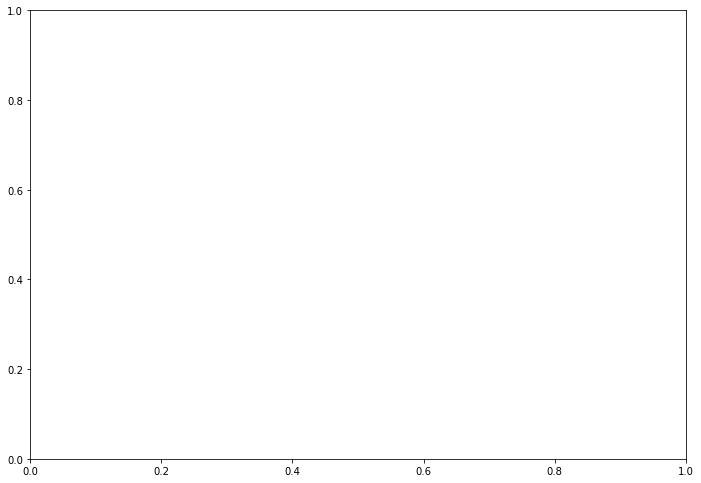

In [35]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1, figsize=(11.75,8.25))
ax.plot(np.arange(0,num_epochs), history.history['loss'], label='Loss', color='red')
ax.plot(np.arange(0,num_epochs), history.history['accuracy'], label='Accuracy', color='blue')
ax.grid(True, which='both')
ax.legend(loc='upper right')
ax.set_xlabel('Epoch')
ax.set_ylabel('Value')
ax.set_xlim(0, num_epochs)
ax.set_ylim(0, 1.1*np.max([np.max(history.history['loss']),np.max(history.history['accuracy'])]))
#ax.set_title(code.capitalize() + ' code ($M_{ep}=2^{' + str(nb_epoch_exp) + '})$ - ' + optimizer_name)

In [36]:
print("Evaluate on test data")
results = best_model.evaluate(X_test, Y_test)
print("test loss, test acc:", results)

Evaluate on test data
17368/17368 [==============================] - 10s 578us/step - loss: 0.8265 - accuracy: 0.6936
test loss, test acc: [0.8265435099601746, 0.6936198472976685]


In [37]:
print(f"Execution finished at {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}.")

Execution finished at 2022-02-19 08:57:11.
